In [2]:
import numpy as np
import matplotlib.pyplot as plt

import keras

from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

import medmnist
from medmnist import INFO

import sys
sys.path.insert(0,"../../")

import dataset_without_pytorch

from functions import split_data, get_label_counts, generate_testing_mixup_images, find_boundary_points
from plotting_functions import plot_3_confusion_matricies, plot_calibration, muba_curves
import pandas as pd


In [2]:
data_flag = 'octmnist'

download = True

image_size = 28

info = INFO[data_flag]

DataClass = getattr(dataset_without_pytorch, info['python_class'])

In [3]:
# load the data
train_dataset = DataClass(split='train', download=download, size = image_size)
test_dataset = DataClass(split='test', download=download, size = image_size)
val_dataset = DataClass(split='val', download=download, size = image_size)

Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\octmnist.npz


In [4]:
RANDOM_SEED = 1

X_train, y_train, X_val, y_val, X_test_A, y_test_A, X_test_B, y_test_B = split_data(
  train_dataset, test_dataset, val_dataset, RANDOM_SEED = RANDOM_SEED, one_hot_encoded = True, num_classes=4, image_size = 28)


In [5]:
# As a sanity check to make sure we have the correct test data, check counts

get_label_counts(y_train,y_val,y_test_A,y_test_B,class_names = ['choroidal neovascularization', 'diabetic macular edema',  'drusen', 'normal'])


Train
{(0, 0, 0, 1): 46026, (0, 0, 1, 0): 7754, (0, 1, 0, 0): 10213, (1, 0, 0, 0): 33484}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']

Val
{(0, 0, 0, 1): 5114, (0, 0, 1, 0): 862, (0, 1, 0, 0): 1135, (1, 0, 0, 0): 3721}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']

Test A
{(0, 0, 0, 1): 69, (0, 0, 1, 0): 72, (0, 1, 0, 0): 80, (1, 0, 0, 0): 79}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']

Test B
{(0, 0, 0, 1): 181, (0, 0, 1, 0): 178, (0, 1, 0, 0): 170, (1, 0, 0, 0): 171}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']


In [6]:
test_set_A_df = pd.DataFrame({
    "image_index":[i for i in range(len(y_test_A))],
    "class":[np.argmax(label) for label in y_test_A]}) # 0 if normal, 1 if pneumonia

In [7]:
MUBA_ITERS = 20

muba_df = generate_testing_mixup_images(test_set_A_df, X_test_A, MUBA_ITERS, classes=4)

In [8]:
muba_df.head(-5)

,alpha_class_0,alpha_class_1,alpha_class_2,alpha_class_3,class_0_index,class_1_index,class_2_index,class_3_index,image,type,label
0,0.011731,0.988269,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[33.62777764712963], [26.709895698602434], [...",mix,1
1,0.067234,0.932766,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[46.06044154317974], [39.531080341404106], [...",mix,1
2,0.137683,0.862317,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[61.84089442904009], [55.80467237994759], [5...",mix,1
3,0.173651,0.826349,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[69.8977868476105], [64.11334268659833], [60...",mix,1
4,0.217640,0.782360,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[79.75126942512964], [74.27474659466493], [7...",mix,1
...,...,...,...,...,...,...,...,...,...,...,...
674130,0.000000,0.000000,0.519387,0.480613,NaN,NaN,281.0,299.0,"[[[20.038774301212797], [21.5193871506064], [2...",mix,2
674131,0.000000,0.000000,0.582309,0.417691,NaN,NaN,281.0,299.0,"[[[20.1646189453217], [21.58230947266085], [23...",mix,2
674132,0.000000,0.000000,0.619567,0.380433,NaN,NaN,281.0,299.0,"[[[20.23913435959065], [21.619567179795325], [...",mix,2
674133,0.000000,0.000000,0.667394,0.332606,NaN,NaN,281.0,299.0,"[[[20.33478874428952], [21.66739437214476], [2...",mix,2


In [9]:
model = keras.models.load_model("best_model_epoch_06.h5")
activations_model = keras.Model(model.input,model.layers[-2].output)

In [10]:
predictions_A = model.predict(X_test_A)
activations_A = activations_model.predict(X_test_A)

predictions_B = model.predict(X_test_B)
activations_B = activations_model.predict(X_test_B)

print("Stacking - this can take some time.")
stacked_images = np.stack(muba_df["image"])
predictions_mixup = model.predict(stacked_images)
activations_mixup = activations_model.predict(stacked_images)

22/22 [==============================] - 0s 8ms/step
Stacking - this can take some time.
21067/21067 [==============================] - 151s 7ms/step


In [11]:
muba_df["predictions_0"] = [p[0] for p in predictions_mixup]
muba_df["predictions_1"] = [p[1] for p in predictions_mixup]
muba_df["predictions_2"] = [p[2] for p in predictions_mixup]
muba_df["predictions_3"] = [p[3] for p in predictions_mixup]
muba_df["argmax_pred"] = [np.argmax(p) for p in predictions_mixup]
muba_df["activations"] = [a for a in activations_mixup]

In [12]:
muba_df.head(-5)

,alpha_class_0,alpha_class_1,alpha_class_2,alpha_class_3,class_0_index,class_1_index,class_2_index,class_3_index,image,type,label,predictions_0,predictions_1,predictions_2,predictions_3,argmax_pred,activations
0,0.011731,0.988269,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[33.62777764712963], [26.709895698602434], [...",mix,1,0.000252,0.999675,0.000051,0.000022,1,"[0.0, 0.0, 0.06831415, 0.3632669, 0.0, 0.0, 0...."
1,0.067234,0.932766,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[46.06044154317974], [39.531080341404106], [...",mix,1,0.000208,0.999681,0.000079,0.000032,1,"[0.0, 0.0, 0.07676872, 0.3915264, 0.0, 0.0, 0...."
2,0.137683,0.862317,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[61.84089442904009], [55.80467237994759], [5...",mix,1,0.000240,0.999563,0.000143,0.000054,1,"[0.0, 0.0, 0.060151897, 0.40346926, 0.0, 0.0, ..."
3,0.173651,0.826349,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[69.8977868476105], [64.11334268659833], [60...",mix,1,0.000328,0.999435,0.000174,0.000063,1,"[0.0, 0.0, 0.046412706, 0.3982008, 0.0, 0.0, 0..."
4,0.217640,0.782360,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[79.75126942512964], [74.27474659466493], [7...",mix,1,0.000604,0.999090,0.000228,0.000078,1,"[0.0, 0.0, 0.019704819, 0.38351437, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674130,0.000000,0.000000,0.519387,0.480613,NaN,NaN,281.0,299.0,"[[[20.038774301212797], [21.5193871506064], [2...",mix,2,0.208612,0.012538,0.709763,0.069088,2,"[0.0, 0.8221516, 0.0, 0.0, 0.9452834, 0.617963..."
674131,0.000000,0.000000,0.582309,0.417691,NaN,NaN,281.0,299.0,"[[[20.1646189453217], [21.58230947266085], [23...",mix,2,0.368784,0.008574,0.596095,0.026547,2,"[0.0, 0.8748247, 0.0, 0.0, 0.76099944, 0.71680..."
674132,0.000000,0.000000,0.619567,0.380433,NaN,NaN,281.0,299.0,"[[[20.23913435959065], [21.619567179795325], [...",mix,2,0.420604,0.006853,0.556531,0.016012,2,"[0.0, 0.8866534, 0.0, 0.0, 0.6752045, 0.753259..."
674133,0.000000,0.000000,0.667394,0.332606,NaN,NaN,281.0,299.0,"[[[20.33478874428952], [21.66739437214476], [2...",mix,2,0.441981,0.005320,0.542740,0.009959,2,"[0.0, 0.90375733, 0.0, 0.0, 0.6142974, 0.78641..."


(array([174590.,      0.,      0., 176000.,      0.,      0., 164160.,
             0.,      0., 159390.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

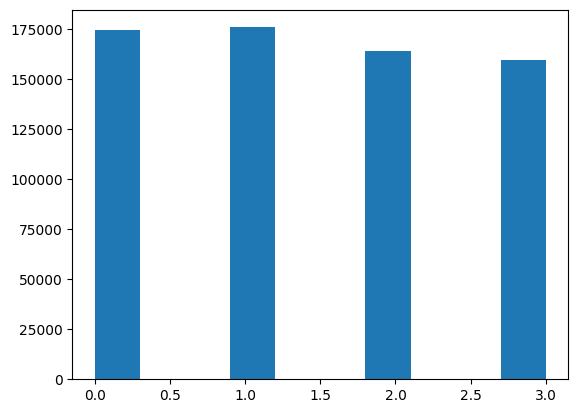

In [13]:
plt.hist(muba_df["label"])

In [14]:
# Check this works
boundary_points_df = find_boundary_points(muba_df, X_test_A, MUBA_ITERS, classes = 4)

In [15]:
boundary_points_df.head(-5)

,alpha_class_0,alpha_class_1,alpha_class_2,alpha_class_3,class_0_index,class_1_index,class_2_index,class_3_index,image,type,label
0,0.500676,0.499324,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[143.15147244489395], [139.6562059587969], [...",boundary,0
1,0.401694,0.598306,0.000000,0.000000,1.0,2.0,NaN,NaN,"[[[130.55225237107354], [127.56071997614742], ...",boundary,1
2,0.242897,0.000000,0.757103,0.000000,1.0,NaN,4.0,NaN,"[[[100.55106438252484], [101.3081670081007], [...",boundary,2
3,0.344945,0.655055,0.000000,0.000000,1.0,5.0,NaN,NaN,"[[[255.0], [255.0], [255.0], [254.0], [253.655...",boundary,1
4,0.342300,0.000000,0.000000,0.657700,1.0,NaN,NaN,6.0,"[[[102.41362844154789], [101.75592856414076], ...",boundary,3
...,...,...,...,...,...,...,...,...,...,...,...
53429,0.000000,0.000000,0.345670,0.654330,NaN,NaN,281.0,293.0,"[[[30.81494708172925], [29.8519576653834], [28...",boundary,3
53430,0.000000,0.000000,0.901441,0.098559,NaN,NaN,281.0,293.0,"[[[22.4783869568181], [23.182709565454477], [2...",boundary,2
53431,0.000000,0.000000,0.250762,0.749238,NaN,NaN,281.0,296.0,"[[[194.07388038472774], [192.82616765245857], ...",boundary,3
53432,0.000000,0.000000,0.360968,0.639032,NaN,NaN,281.0,296.0,"[[[168.61643134060276], [167.69933482968582], ...",boundary,3


In [16]:
predictions_boundary = model.predict(np.stack(boundary_points_df["image"]))
activations_boundary = activations_model.predict(np.stack(boundary_points_df["image"]))

1670/1670 [==============================] - 15s 9ms/step


In [17]:
test_set_A_df = pd.DataFrame({
    "alpha_class_0" : [label[0] for label in y_test_A],
    "alpha_class_1" : [label[1] for label in y_test_A],
    "alpha_class_2" : [label[2] for label in y_test_A],
    "alpha_class_3" : [label[3] for label in y_test_A],
    "class_0_index" : None,
    "class_1_index" : None,
    "class_2_index" : None,
    "class_3_index" : None,
    "image" : [image for image in X_test_A],
    "type" : "A",
    "label" : [np.argmax(l) for l in y_test_A],
    "predictions_0" : [p[0] for p in predictions_A],
    "predictions_1" : [p[1] for p in predictions_A],
    "predictions_2" : [p[2] for p in predictions_A],
    "predictions_3" : [p[3] for p in predictions_A],
    "argmax_pred" : [np.argmax(p) for p in predictions_A],
    "activations" : [a for a in activations_A]
})
test_set_B_df = pd.DataFrame({
    "alpha_class_0" : [label[0] for label in y_test_B],
    "alpha_class_1" : [label[1] for label in y_test_B],
    "alpha_class_2" : [label[2] for label in y_test_B],
    "alpha_class_3" : [label[3] for label in y_test_B],
    "class_0_index" : None,
    "class_1_index" : None,
    "class_2_index" : None,
    "class_3_index" : None,
    "image" : [image for image in X_test_B],
    "type" : "B",
    "label" : [np.argmax(l) for l in y_test_B],
    "predictions_0" : [p[0] for p in predictions_B],
    "predictions_1" : [p[1] for p in predictions_B],
    "predictions_2" : [p[2] for p in predictions_B],
    "predictions_3" : [p[3] for p in predictions_B],
    "argmax_pred" : [np.argmax(p) for p in predictions_B],
    "activations" : [a for a in activations_B]
})

boundary_points_df["predictions_0"] = [p[0] for p in predictions_boundary]
boundary_points_df["predictions_1"] = [p[1] for p in predictions_boundary]
boundary_points_df["predictions_2"] = [p[0] for p in predictions_boundary]
boundary_points_df["predictions_3"] = [p[1] for p in predictions_boundary]
boundary_points_df["argmax_pred"] = [np.argmax(p) for p in predictions_boundary]
boundary_points_df["activations"] = [a for a in activations_boundary]

In [18]:
df = pd.concat([test_set_A_df, test_set_B_df, muba_df, boundary_points_df],axis=0, ignore_index=True)

In [19]:
muba_projections = TSNE(2,random_state=1, verbose = 2).fit_transform(np.stack(df["activations"]))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 728579 samples in 0.044s...
[t-SNE] Computed neighbors for 728579 samples in 1985.736s...
[t-SNE] Computed conditional probabilities for sample 1000 / 728579
[t-SNE] Computed conditional probabilities for sample 2000 / 728579
[t-SNE] Computed conditional probabilities for sample 3000 / 728579
[t-SNE] Computed conditional probabilities for sample 4000 / 728579
[t-SNE] Computed conditional probabilities for sample 5000 / 728579
[t-SNE] Computed conditional probabilities for sample 6000 / 728579
[t-SNE] Computed conditional probabilities for sample 7000 / 728579
[t-SNE] Computed conditional probabilities for sample 8000 / 728579
[t-SNE] Computed conditional probabilities for sample 9000 / 728579
[t-SNE] Computed conditional probabilities for sample 10000 / 728579
[t-SNE] Computed conditional probabilities for sample 11000 / 728579
[t-SNE] Computed conditional probabilities for sample 12000 / 728579
[t-SNE] Computed conditional prob

In [20]:
df["projection_x"] = [x[0] for x in muba_projections]
df["projection_y"] = [x[1] for x in muba_projections]

In [21]:
df_to_save = df.drop(columns=["image"])
df_to_save.to_pickle("muba_df.csv")

In [3]:
df = pd.read_pickle("muba_df.csv")

In [4]:
true_images_A_df = df[df["type"] == "A"]
true_images_B_df = df[df["type"] == "B"]

mixup_images_df =  df[df["type"] == "mix"]
boundary_images_df = df[df["type"] == "boundary"]

true_A_class_0 = true_images_A_df[true_images_A_df["label"] == 0]
true_A_class_1 = true_images_A_df[true_images_A_df["label"] == 1]
true_A_class_2 = true_images_A_df[true_images_A_df["label"] == 2]
true_A_class_3 = true_images_A_df[true_images_A_df["label"] == 3]

true_B_class_0 = true_images_B_df[true_images_B_df["label"] == 0]
true_B_class_1 = true_images_B_df[true_images_B_df["label"] == 1]
true_B_class_2 = true_images_B_df[true_images_B_df["label"] == 2]
true_B_class_3 = true_images_B_df[true_images_B_df["label"] == 3]

mixup_0 = mixup_images_df[mixup_images_df["label"] == 0]
mixup_1 = mixup_images_df[mixup_images_df["label"] == 1]
mixup_2 = mixup_images_df[mixup_images_df["label"] == 2]
mixup_3 = mixup_images_df[mixup_images_df["label"] == 3]

true_A_errors = true_images_A_df[true_images_A_df["label"] != true_images_A_df["argmax_pred"]]
true_B_errors = true_images_B_df[true_images_B_df["label"] != true_images_B_df["argmax_pred"]]
mixup_errors = mixup_images_df[mixup_images_df["label"] != mixup_images_df["argmax_pred"]]

error_free_true_A_class_0 = true_A_class_0[true_A_class_0["label"] == true_A_class_0["argmax_pred"]]
error_free_true_A_class_1 = true_A_class_1[true_A_class_1["label"] == true_A_class_1["argmax_pred"]]
error_free_true_A_class_2 = true_A_class_2[true_A_class_2["label"] == true_A_class_2["argmax_pred"]]
error_free_true_A_class_3 = true_A_class_3[true_A_class_3["label"] == true_A_class_3["argmax_pred"]]

error_free_mixup_class_0 = mixup_0[mixup_0["label"] == mixup_0["argmax_pred"]]
error_free_mixup_class_1 = mixup_1[mixup_1["label"] == mixup_1["argmax_pred"]]
error_free_mixup_class_2 = mixup_2[mixup_2["label"] == mixup_2["argmax_pred"]]
error_free_mixup_class_3 = mixup_3[mixup_3["label"] == mixup_3["argmax_pred"]]

In [5]:
true_images_B_df

,alpha_class_0,alpha_class_1,alpha_class_2,alpha_class_3,class_0_index,class_1_index,class_2_index,class_3_index,type,label,predictions_0,predictions_1,predictions_2,predictions_3,argmax_pred,activations,projection_x,projection_y
300,1.0,0.0,0.0,0.0,None,None,None,None,B,0,0.911417,0.082613,0.005583,0.000387,0,"[0.16470931, 0.20861353, 0.0, 0.0, 0.048472106...",-98.456543,5.108192
301,0.0,0.0,1.0,0.0,None,None,None,None,B,2,0.307588,0.010527,0.673170,0.008715,2,"[0.0, 0.850114, 0.0, 0.0, 0.34593135, 0.722804...",-7.087101,-50.599464
302,0.0,0.0,0.0,1.0,None,None,None,None,B,3,0.000026,0.012276,0.045288,0.942410,3,"[0.0, 0.0, 0.0, 0.0, 3.0195441, 0.0, 1.2678626...",118.401108,45.640862
303,0.0,1.0,0.0,0.0,None,None,None,None,B,1,0.358847,0.633729,0.006913,0.000511,1,"[0.10772318, 0.07940362, 0.0, 0.24711496, 0.0,...",-92.802246,38.212357
304,0.0,0.0,0.0,1.0,None,None,None,None,B,3,0.018801,0.029388,0.553590,0.398222,2,"[0.0, 0.41456777, 0.0, 0.0, 1.2135445, 0.10283...",81.076546,-53.817188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,1.0,None,None,None,None,B,3,0.092490,0.146181,0.261563,0.499766,3,"[0.0, 0.0, 0.0, 0.0, 0.5342746, 0.0, 0.0970622...",55.864941,-2.638831
996,0.0,0.0,1.0,0.0,None,None,None,None,B,2,0.143839,0.026538,0.673916,0.155707,2,"[0.0, 0.5212047, 0.0, 0.0, 1.0346119, 0.471317...",91.351280,-73.481628
997,0.0,0.0,1.0,0.0,None,None,None,None,B,2,0.146960,0.045126,0.749326,0.058587,2,"[0.0, 0.62794733, 0.0, 0.0, 0.47922784, 0.5751...",55.071369,-79.231071
998,1.0,0.0,0.0,0.0,None,None,None,None,B,0,0.639926,0.352270,0.007245,0.000559,0,"[0.05605472, 0.21250656, 0.0, 0.16760492, 0.07...",-83.936371,32.428436


In [6]:
mixup_errors_0_1 = mixup_errors[(mixup_errors["alpha_class_0"] > 0) & (mixup_errors["alpha_class_1"] > 0)]
mixup_errors_0_2 = mixup_errors[(mixup_errors["alpha_class_0"] > 0) & (mixup_errors["alpha_class_2"] > 0)]
mixup_errors_0_3 = mixup_errors[(mixup_errors["alpha_class_0"] > 0) & (mixup_errors["alpha_class_3"] > 0)]
mixup_errors_1_2 = mixup_errors[(mixup_errors["alpha_class_1"] > 0) & (mixup_errors["alpha_class_2"] > 0)]
mixup_errors_1_3 = mixup_errors[(mixup_errors["alpha_class_1"] > 0) & (mixup_errors["alpha_class_3"] > 0)]
mixup_errors_2_3 = mixup_errors[(mixup_errors["alpha_class_2"] > 0) & (mixup_errors["alpha_class_3"] > 0)]

boundaries_0_1 = boundary_images_df[(boundary_images_df["alpha_class_0"] > 0) & (boundary_images_df["alpha_class_1"] > 0)]
boundaries_0_2 = boundary_images_df[(boundary_images_df["alpha_class_0"] > 0) & (boundary_images_df["alpha_class_2"] > 0)]
boundaries_0_3 = boundary_images_df[(boundary_images_df["alpha_class_0"] > 0) & (boundary_images_df["alpha_class_3"] > 0)]
boundaries_1_2 = boundary_images_df[(boundary_images_df["alpha_class_1"] > 0) & (boundary_images_df["alpha_class_2"] > 0)]
boundaries_1_3 = boundary_images_df[(boundary_images_df["alpha_class_1"] > 0) & (boundary_images_df["alpha_class_3"] > 0)]
boundaries_2_3 = boundary_images_df[(boundary_images_df["alpha_class_2"] > 0) & (boundary_images_df["alpha_class_3"] > 0)]

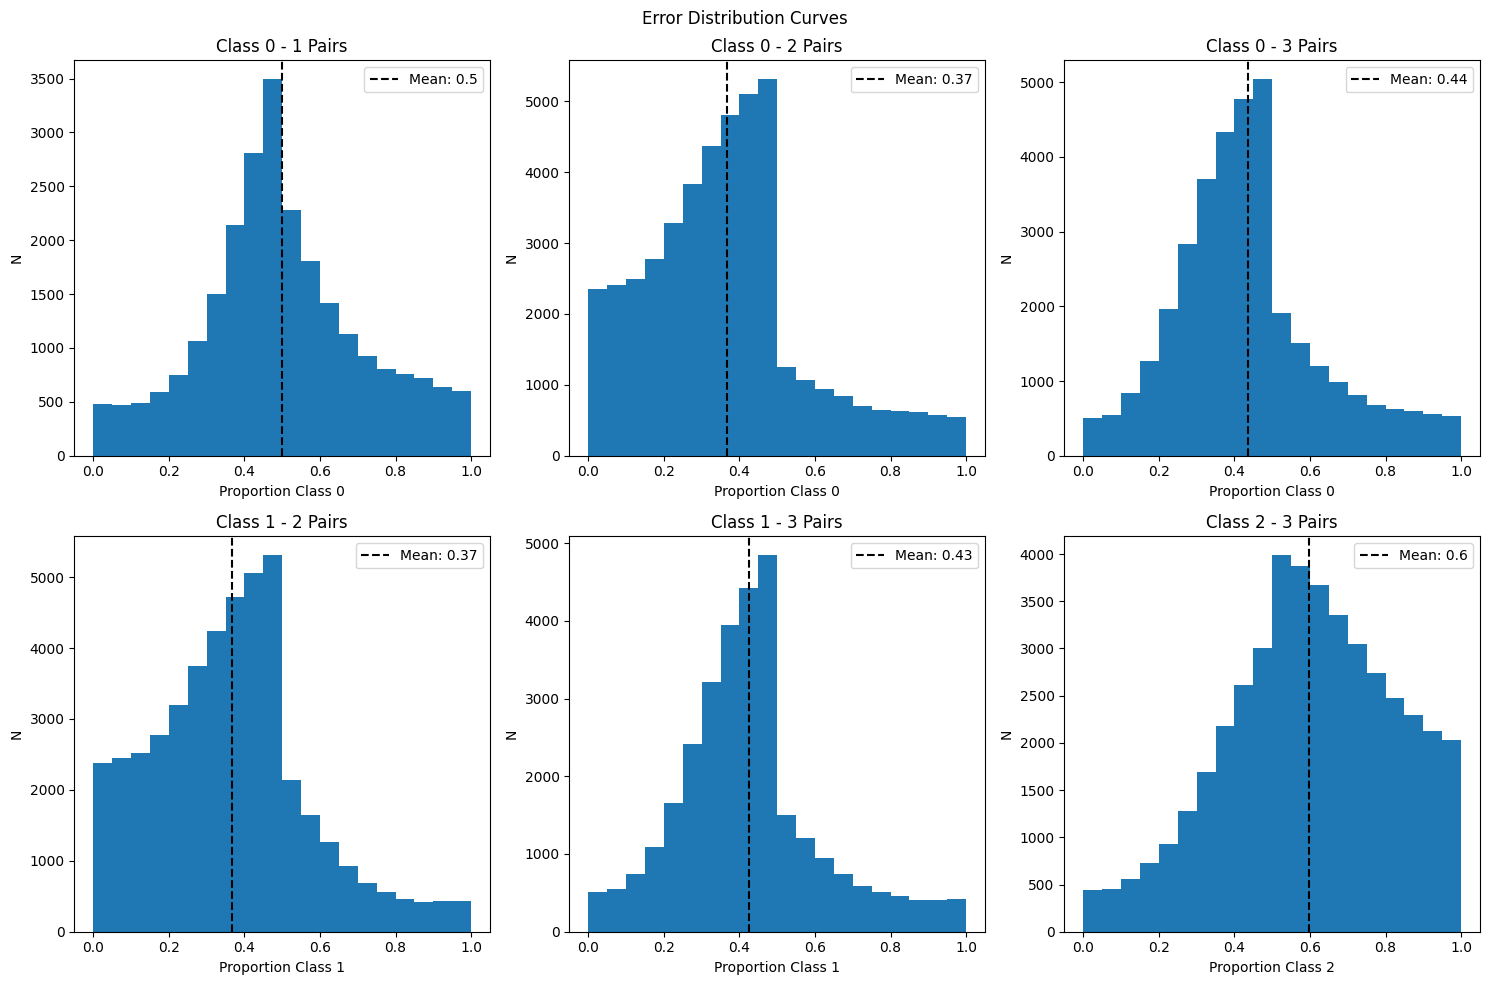

In [7]:
fig, axs = plt.subplots(2,3,figsize=(15,10))

#x_labels = ['Proportion Choroidal Neovascularization', 'Proportion Choroidal Neovascularization', 'Proportion Choroidal Neovascularization', 'Proportion Diabetic Macular Edema', 'Proportion Diabetic Macular Edema', 'Proportion Drusen']
x_labels=["Proportion Class 0", "Proportion Class 0", "Proportion Class 0", "Proportion Class 1", "Proportion Class 1", "Proportion Class 2"]
alpha_keys = ["alpha_class_0","alpha_class_0","alpha_class_0","alpha_class_1","alpha_class_1","alpha_class_2"]
titles = ["Class 0 - 1 Pairs","Class 0 - 2 Pairs","Class 0 - 3 Pairs","Class 1 - 2 Pairs","Class 1 - 3 Pairs","Class 2 - 3 Pairs",]
errors = [mixup_errors_0_1,mixup_errors_0_2,mixup_errors_0_3,mixup_errors_1_2,mixup_errors_1_3,mixup_errors_2_3]

for ax, x, e, key, t in zip(axs.flat, x_labels, errors, alpha_keys, titles):
    ax.hist(e[key], bins = [i/20 for i in range(21)])
    ax.set_xlabel(x)
    ax.set_ylabel("N")
    ax.set_title(t)
    ax.axvline(np.mean(e[key]),linestyle = "--", color = "black",label=f"Mean: {round(np.mean(e[key]),2)}")
    ax.legend()

plt.suptitle("Error Distribution Curves")
fig.tight_layout()

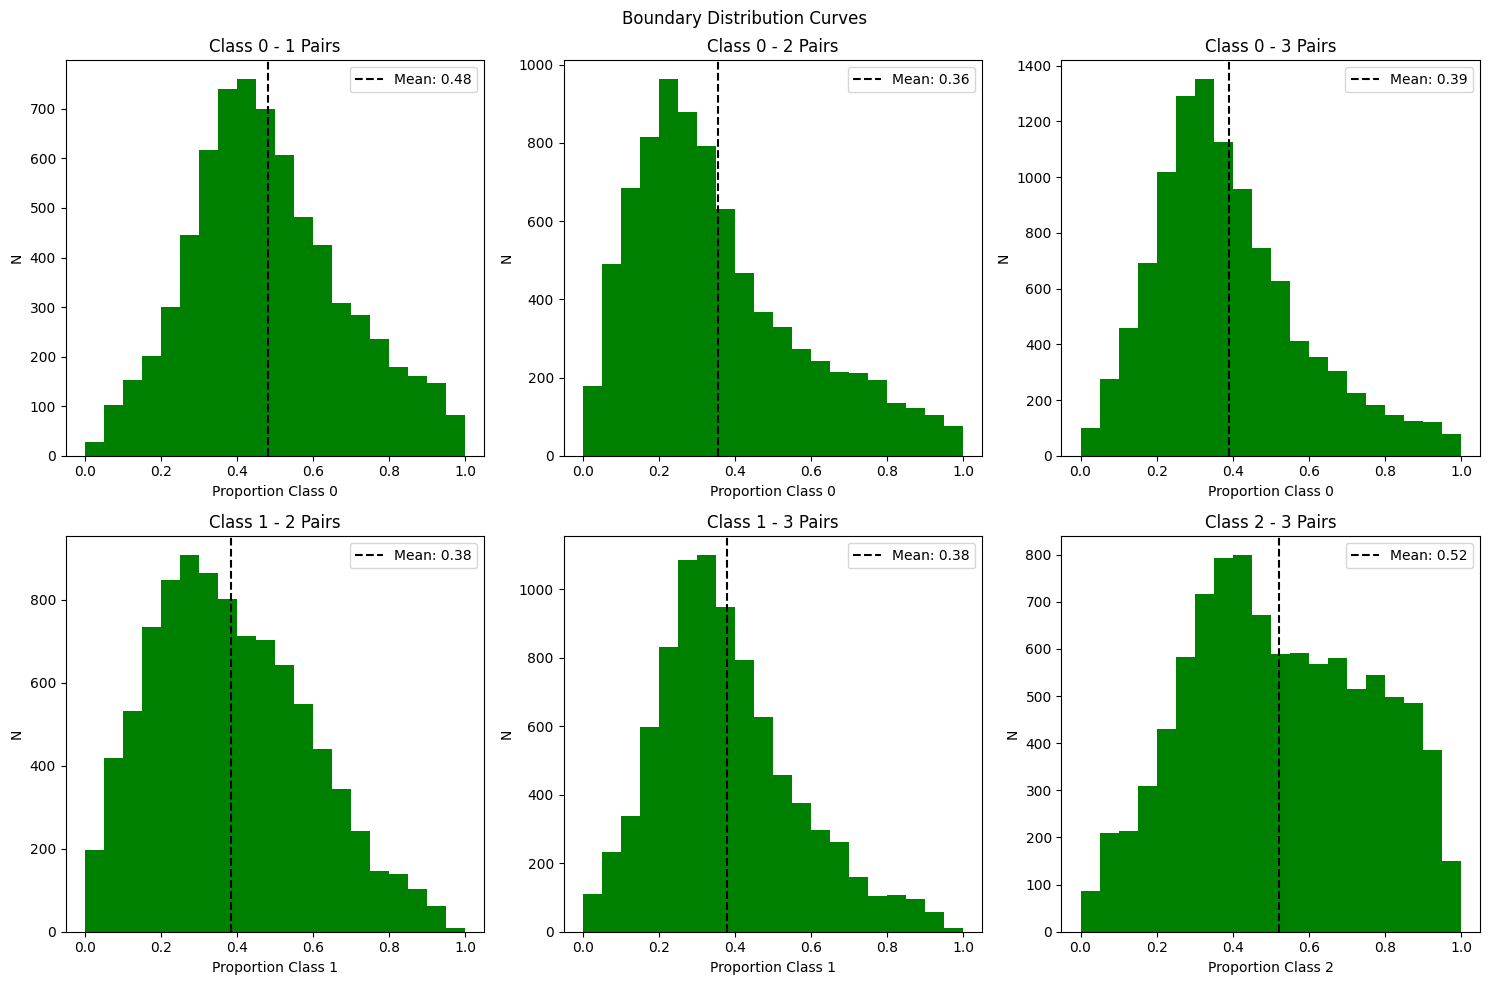

In [8]:
fig, axs = plt.subplots(2,3,figsize=(15,10))

#x_labels = ['Proportion Choroidal Neovascularization', 'Proportion Choroidal Neovascularization', 'Proportion Choroidal Neovascularization', 'Proportion Diabetic Macular Edema', 'Proportion Diabetic Macular Edema', 'Proportion Drusen']
x_labels=["Proportion Class 0", "Proportion Class 0", "Proportion Class 0", "Proportion Class 1", "Proportion Class 1", "Proportion Class 2"]
alpha_keys = ["alpha_class_0","alpha_class_0","alpha_class_0","alpha_class_1","alpha_class_1","alpha_class_2"]
titles = ["Class 0 - 1 Pairs","Class 0 - 2 Pairs","Class 0 - 3 Pairs","Class 1 - 2 Pairs","Class 1 - 3 Pairs","Class 2 - 3 Pairs",]
errors = [boundaries_0_1,boundaries_0_2,boundaries_0_3,boundaries_1_2,boundaries_1_3,boundaries_2_3]

for ax, x, e, key, t in zip(axs.flat, x_labels, errors, alpha_keys, titles):
    ax.hist(e[key], bins = [i/20 for i in range(21)], color="green")
    ax.set_xlabel(x)
    ax.set_ylabel("N")
    ax.set_title(t)
    ax.axvline(np.mean(e[key]),linestyle = "--", color = "black",label=f"Mean: {round(np.mean(e[key]),2)}")
    ax.legend()

plt.suptitle("Boundary Distribution Curves")
fig.tight_layout()

In [9]:
print(classification_report(mixup_images_df["label"],mixup_images_df["argmax_pred"]))

              precision    recall  f1-score   support

           0       0.61      0.84      0.70    174590
           1       0.66      0.83      0.73    176000
           2       0.72      0.37      0.49    164160
           3       0.77      0.60      0.68    159390

    accuracy                           0.67    674140
   macro avg       0.69      0.66      0.65    674140
weighted avg       0.69      0.67      0.65    674140



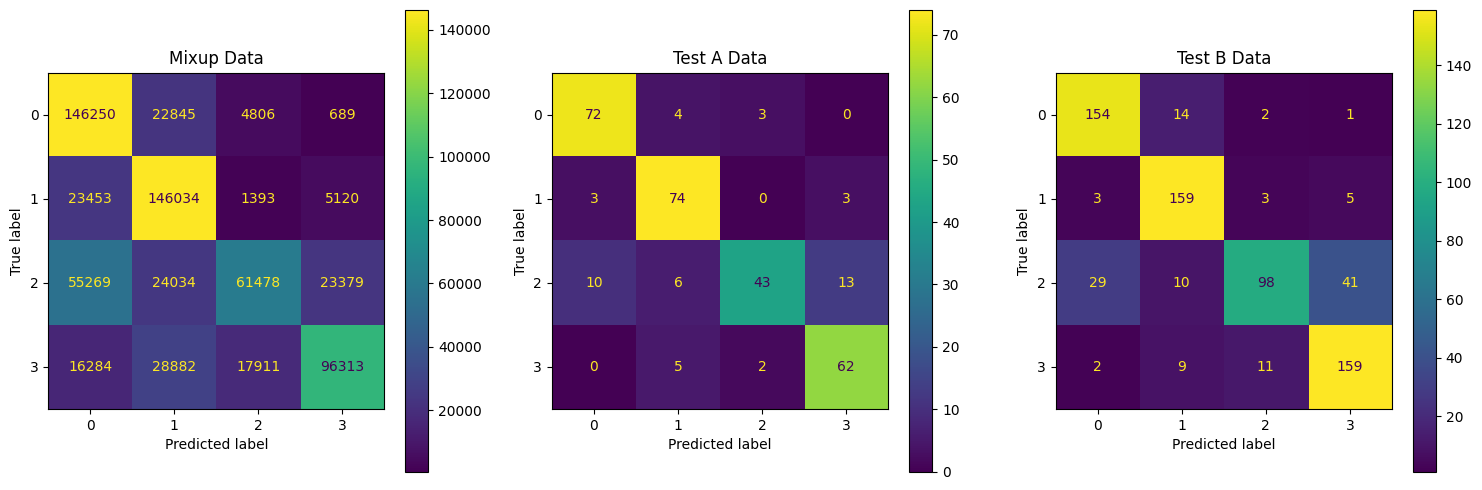

In [10]:
plot_3_confusion_matricies(mixup_images_df,true_images_A_df,true_images_B_df, labels = [0,1,2,3])

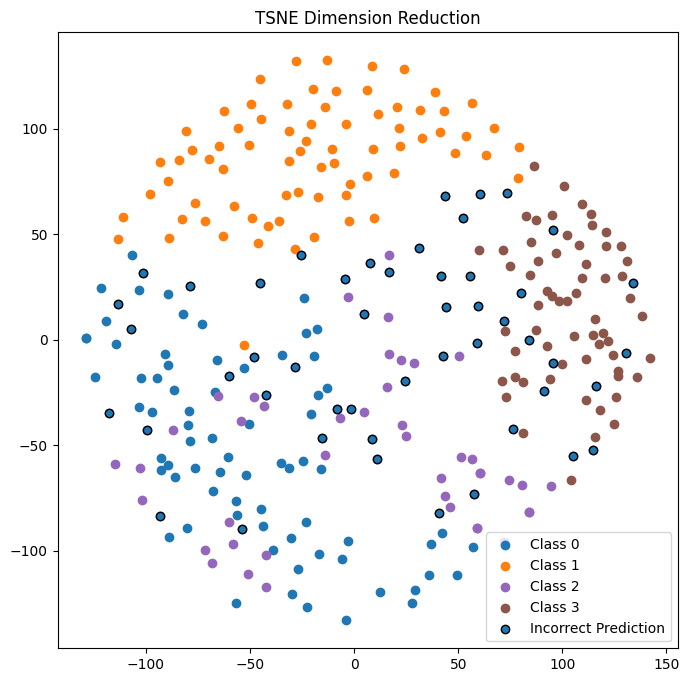

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(true_A_class_0["projection_x"], true_A_class_0["projection_y"], color = "C0", label = "Class 0")
ax.scatter(true_A_class_1["projection_x"], true_A_class_1["projection_y"], color = "C1", label = "Class 1")
ax.scatter(true_A_class_2["projection_x"], true_A_class_2["projection_y"], color = "C4", label = "Class 2")
ax.scatter(true_A_class_3["projection_x"], true_A_class_3["projection_y"], color = "C5", label = "Class 3")

ax.scatter(true_A_errors["projection_x"], true_A_errors["projection_y"], color = None, edgecolors = "black", label = "Incorrect Prediction")

ax.set_title("TSNE Dimension Reduction")
ax.legend()

C:\Users\Will Poulett\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\Will Poulett\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


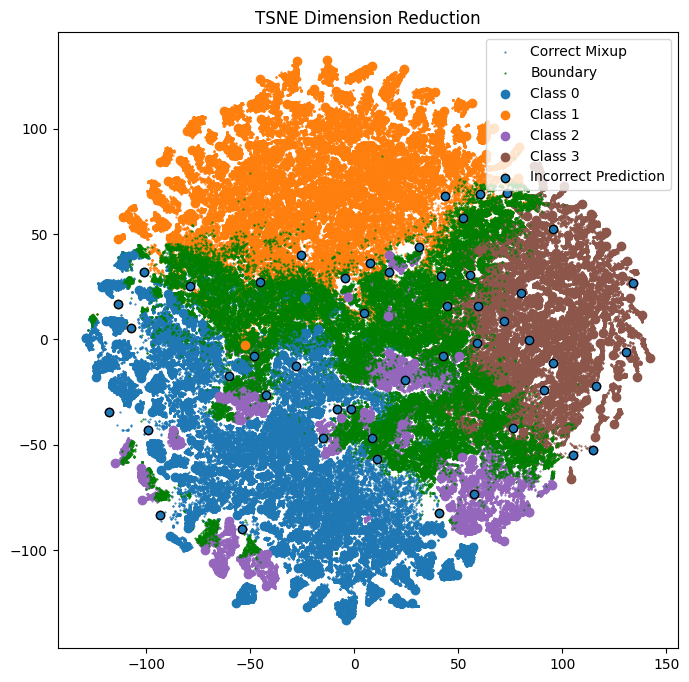

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(error_free_mixup_class_0["projection_x"],error_free_mixup_class_0["projection_y"], color = "C0", marker = ".", s = 1, label = "Correct Mixup")
ax.scatter(error_free_mixup_class_1["projection_x"],error_free_mixup_class_1["projection_y"], color = "C1", marker = ".", s = 1)
ax.scatter(error_free_mixup_class_2["projection_x"],error_free_mixup_class_2["projection_y"], color = "C4", marker = ".", s = 1)
ax.scatter(error_free_mixup_class_3["projection_x"],error_free_mixup_class_3["projection_y"], color = "C5", marker = ".", s = 1)
ax.scatter(boundary_images_df["projection_x"],boundary_images_df["projection_y"], color = "green", marker = ".", s = 1, label = "Boundary")

ax.scatter(true_A_class_0["projection_x"], true_A_class_0["projection_y"], color = "C0", label = "Class 0")
ax.scatter(true_A_class_1["projection_x"], true_A_class_1["projection_y"], color = "C1", label = "Class 1")
ax.scatter(true_A_class_2["projection_x"], true_A_class_2["projection_y"], color = "C4", label = "Class 2")
ax.scatter(true_A_class_3["projection_x"], true_A_class_3["projection_y"], color = "C5", label = "Class 3")

ax.scatter(true_A_errors["projection_x"], true_A_errors["projection_y"], color = None, edgecolors = "black", label = "Incorrect Prediction")

ax.set_title("TSNE Dimension Reduction")
ax.legend()

In [13]:
from scipy import spatial
from collections import Counter

def get_distances():

    all_images_without_B_df = df[df["type"] != "B"].reset_index()
    activations_A = [a for a in true_images_A_df["activations"]]
    activations_B = [a for a in true_images_B_df["activations"]]
    activations_mixup = [a for a in mixup_images_df["activations"]]
    activations_boundary = [a for a in boundary_images_df["activations"]]
    all = [a for a in all_images_without_B_df["activations"]]

    tree_true_A = spatial.KDTree(activations_A)
    tree_true_B = spatial.KDTree(activations_B)
    tree_mixup  = spatial.KDTree(activations_mixup)
    tree_boundaries = spatial.KDTree(activations_boundary)
    tree_all = spatial.KDTree(all)

    distances_to_all = []
    distances_B_to_boundary = []
    distances_B_to_mixup = []
    B_class_0_to_boundary = []
    B_class_1_to_boundary = []
    B_class_2_to_boundary = []
    B_class_3_to_boundary = []
    B_class_0_correct_to_boundary = []
    B_class_1_correct_to_boundary = []
    B_class_2_correct_to_boundary = []
    B_class_3_correct_to_boundary = []
    B_class_0_incorrect_to_boundary = []
    B_class_1_incorrect_to_boundary = []
    B_class_2_incorrect_to_boundary = []
    B_class_3_incorrect_to_boundary = []
    types = []
    distance_B_to_B = []
    
    distances_A_to_boundary = []
    A_class_0_to_boundary = []
    A_class_1_to_boundary = []
    A_class_2_to_boundary = []
    A_class_3_to_boundary = []
    A_class_0_incorrect_to_boundary = []
    A_class_1_incorrect_to_boundary = []
    A_class_2_incorrect_to_boundary = []
    A_class_3_incorrect_to_boundary = []
    distance_A_to_A = []

    for vector, label, pred in zip(activations_B,true_images_B_df["label"],true_images_B_df["argmax_pred"]):

        distance, id = tree_all.query(vector)
        types.append(all_images_without_B_df.loc[[id]]["type"][id])
        distances_to_all.append(distance)

        boundary_dist = tree_boundaries.query(vector)[0]

        distance_B_to_B.append(tree_true_B.query(vector,2)[0][1])
        distances_B_to_boundary.append(boundary_dist)
        distances_B_to_mixup.append(tree_mixup.query(vector)[0])

        if label == 0:
            B_class_0_to_boundary.append(boundary_dist)
            if pred != 0:#Incorrect
                B_class_0_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_0_correct_to_boundary.append(boundary_dist)
        elif label == 1:
            B_class_1_to_boundary.append(boundary_dist)
            if pred != 1:#Incorrect
                B_class_1_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_1_correct_to_boundary.append(boundary_dist)
        elif label == 2:
            B_class_2_to_boundary.append(boundary_dist)
            if pred != 2:#Incorrect
                B_class_2_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_2_correct_to_boundary.append(boundary_dist)
        elif label == 3:
            B_class_3_to_boundary.append(boundary_dist)
            if pred != 3:#Incorrect
                B_class_3_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_3_correct_to_boundary.append(boundary_dist)

    for vector, label, pred in zip(activations_A, true_images_A_df["label"],true_images_A_df["argmax_pred"]):

        boundary_dist = tree_boundaries.query(vector)[0]

        distance_A_to_A.append(tree_true_A.query(vector,2)[0][1])
        distances_A_to_boundary.append(boundary_dist)

        if label == 0:
            A_class_0_to_boundary.append(boundary_dist)
            if pred != 0: #Incorrect
                A_class_0_incorrect_to_boundary.append(boundary_dist)
        elif label == 1:
            A_class_1_to_boundary.append(boundary_dist)
            if pred != 1: #Incorrect
                A_class_1_incorrect_to_boundary.append(boundary_dist)
        elif label == 2:
            A_class_2_to_boundary.append(boundary_dist)
            if pred != 2: #Incorrect
                A_class_2_incorrect_to_boundary.append(boundary_dist)
        elif label == 3:
            A_class_3_to_boundary.append(boundary_dist)
            if pred != 3:#Incorrect
                A_class_3_incorrect_to_boundary.append(boundary_dist)

    counts = Counter(types)

   
    return distances_B_to_boundary, B_class_0_to_boundary, B_class_1_to_boundary, B_class_2_to_boundary, B_class_3_to_boundary, B_class_0_correct_to_boundary, B_class_1_correct_to_boundary, B_class_2_correct_to_boundary, B_class_3_correct_to_boundary

In [14]:
distances_B_to_boundary, B_class_0_to_boundary, B_class_1_to_boundary, B_class_2_to_boundary, B_class_3_to_boundary, B_class_0_correct_to_boundary, B_class_1_correct_to_boundary, B_class_2_correct_to_boundary, B_class_3_correct_to_boundary = get_distances()


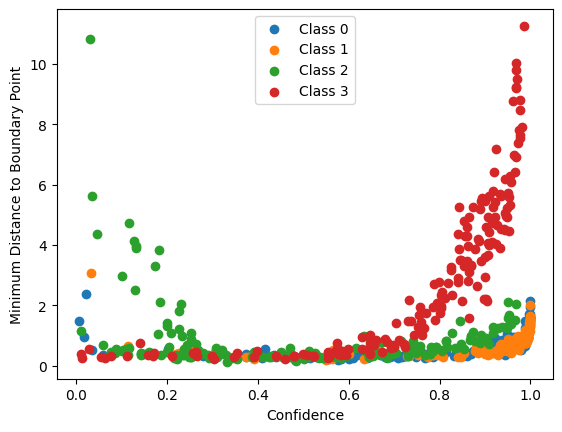

In [15]:
plt.scatter(true_images_B_df[true_images_B_df["label"]==0]["predictions_0"],B_class_0_to_boundary, label = "Class 0")
plt.scatter(true_images_B_df[true_images_B_df["label"]==1]["predictions_1"],B_class_1_to_boundary, label = "Class 1")
plt.scatter(true_images_B_df[true_images_B_df["label"]==2]["predictions_2"],B_class_2_to_boundary, label = "Class 2")
plt.scatter(true_images_B_df[true_images_B_df["label"]==3]["predictions_3"],B_class_3_to_boundary, label = "Class 3")
plt.xlabel("Confidence")
plt.ylabel("Minimum Distance to Boundary Point")
plt.legend()

In [16]:
multiple_boundaries_mask = boundary_images_df.duplicated(subset=["class_0_index","class_1_index"], keep=False)
multiple_boundaries = boundary_images_df[multiple_boundaries_mask]

In [17]:
multiple_boundaries

,alpha_class_0,alpha_class_1,alpha_class_2,alpha_class_3,class_0_index,class_1_index,class_2_index,class_3_index,type,label,predictions_0,predictions_1,predictions_2,predictions_3,argmax_pred,activations,projection_x,projection_y
675142,0.242897,0.0,0.757103,0.000000,1.0,NaN,4.0,NaN,boundary,2,0.438826,0.047750,0.438826,0.047750,0,"[0.014710993, 0.5106675, 0.0, 0.0, 0.81619966,...",42.401241,-47.284973
675144,0.342300,0.0,0.000000,0.657700,1.0,NaN,NaN,6.0,boundary,3,0.304166,0.108347,0.304166,0.108347,3,"[0.0, 0.28092188, 0.0, 0.0, 0.65080684, 0.1004...",42.575832,-37.298954
675146,0.504704,0.0,0.495296,0.000000,1.0,NaN,8.0,NaN,boundary,0,0.426114,0.280200,0.426114,0.280200,0,"[0.12848575, 0.39388397, 0.0, 0.21812004, 0.33...",-1.304333,-0.887348
675148,0.306379,0.0,0.000000,0.693621,1.0,NaN,NaN,10.0,boundary,3,0.043088,0.433436,0.043088,0.433436,1,"[0.0, 0.04320068, 0.0, 0.1695835, 0.3138147, 0...",39.850422,41.322117
675149,0.364282,0.0,0.000000,0.635718,1.0,NaN,NaN,10.0,boundary,3,0.350349,0.441590,0.350349,0.441590,1,"[0.15887253, 0.24037898, 0.0, 0.14295739, 0.24...",-11.751007,7.619074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728574,0.000000,0.0,0.947803,0.052197,NaN,NaN,281.0,296.0,boundary,2,0.378890,0.001421,0.378890,0.001421,2,"[0.0, 0.9662111, 0.0, 0.0, 0.2262761, 0.891095...",-95.399734,-73.822845
728575,0.000000,0.0,0.182438,0.817562,NaN,NaN,281.0,297.0,boundary,3,0.024632,0.342202,0.024632,0.342202,2,"[0.0, 0.15530762, 0.0, 0.2743808, 0.4021777, 0...",33.981537,23.832014
728576,0.000000,0.0,0.487696,0.512304,NaN,NaN,281.0,297.0,boundary,3,0.179965,0.289622,0.179965,0.289622,2,"[0.0024796724, 0.2981253, 0.0, 0.15864107, 0.4...",13.777824,5.726445
728577,0.000000,0.0,0.887101,0.112899,NaN,NaN,281.0,297.0,boundary,2,0.512440,0.002686,0.512440,0.002686,0,"[0.0, 0.91854155, 0.0, 0.0, 0.24107644, 0.8500...",-92.325752,-72.424278


In [18]:
POINT_0 = 1
POINT_1 = 278

POINT_0_df = true_A_class_0.loc[[POINT_0]]
POINT_1_df = true_A_class_1.loc[[POINT_1]]

point_1_df = mixup_images_df[mixup_images_df["class_0_index"]==POINT_0]
path_df = point_1_df[point_1_df["class_1_index"]==POINT_1]

boundary_points_1 = boundary_images_df[boundary_images_df["class_0_index"]==POINT_0]
boundary_point = boundary_points_1[boundary_points_1["class_1_index"]==POINT_1]

if len(POINT_0_df) == 0:
    print(f"Point {POINT_0} is not in this class")
if len(POINT_1_df) == 0:
    print(f"Point {POINT_1} is not in this class")

path_df = pd.concat([POINT_0_df, POINT_1_df, boundary_point, path_df],axis=0,ignore_index=False).sort_values("alpha_class_0")


C:\Users\Will Poulett\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\Will Poulett\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


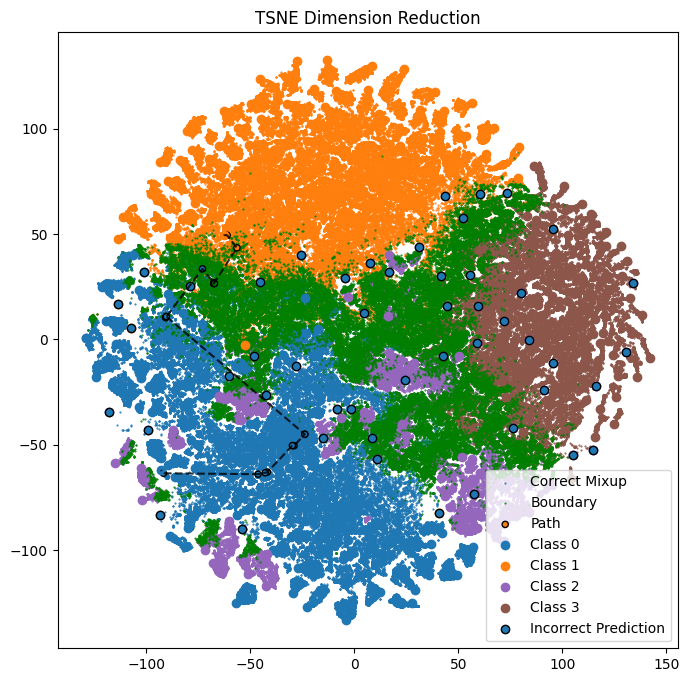

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(error_free_mixup_class_0["projection_x"],error_free_mixup_class_0["projection_y"], color = "C0", marker = ".", s = 1, label = "Correct Mixup")
ax.scatter(error_free_mixup_class_1["projection_x"],error_free_mixup_class_1["projection_y"], color = "C1", marker = ".", s = 1)
ax.scatter(error_free_mixup_class_2["projection_x"],error_free_mixup_class_2["projection_y"], color = "C4", marker = ".", s = 1)
ax.scatter(error_free_mixup_class_3["projection_x"],error_free_mixup_class_3["projection_y"], color = "C5", marker = ".", s = 1)
ax.scatter(boundary_images_df["projection_x"],boundary_images_df["projection_y"], color = "green", marker = ".", s = 1, label = "Boundary")
ax.plot(path_df["projection_x"],path_df["projection_y"],alpha=0.8,linestyle="--",color="black")

ax.scatter(path_df["projection_x"],path_df["projection_y"],marker="o",s=20,c=["C0" if l == 0 else "C1" for l in path_df["argmax_pred"]], edgecolors = "black",label="Path")
ax.scatter(boundary_point["projection_x"],boundary_point["projection_y"],marker="o",s=20,c="green", edgecolors = "black")

ax.scatter(true_A_class_0["projection_x"], true_A_class_0["projection_y"], color = "C0", label = "Class 0")
ax.scatter(true_A_class_1["projection_x"], true_A_class_1["projection_y"], color = "C1", label = "Class 1")
ax.scatter(true_A_class_2["projection_x"], true_A_class_2["projection_y"], color = "C4", label = "Class 2")
ax.scatter(true_A_class_3["projection_x"], true_A_class_3["projection_y"], color = "C5", label = "Class 3")

ax.scatter(true_A_errors["projection_x"], true_A_errors["projection_y"], color = None, edgecolors = "black", label = "Incorrect Prediction")

ax.set_title("TSNE Dimension Reduction")
ax.legend()

In [20]:
from scipy import spatial
from collections import Counter

# This may be a function that we want to change for different models, so we define it within the notebook.
def get_distances():

    all_images_without_B_df = df[df["type"] != "B"].reset_index()
    activations_A = [a for a in true_images_A_df["activations"]]
    activations_B = [a for a in true_images_B_df["activations"]]
    activations_mixup = [a for a in mixup_images_df["activations"]]
    activations_boundary = [a for a in boundary_images_df["activations"]]
    all = [a for a in all_images_without_B_df["activations"]]

    tree_true_A = spatial.KDTree(activations_A)
    tree_true_B = spatial.KDTree(activations_B)
    tree_mixup  = spatial.KDTree(activations_mixup)
    tree_boundaries = spatial.KDTree(activations_boundary)
    tree_all = spatial.KDTree(all)

    distances_to_all = []
    distances_B_to_boundary = []
    distances_B_to_mixup = []
    B_class_0_to_boundary = []
    B_class_1_to_boundary = []
    B_class_2_to_boundary = []
    B_class_3_to_boundary = []
    B_class_0_incorrect_to_boundary = []
    B_class_1_incorrect_to_boundary = []
    B_class_2_incorrect_to_boundary = []
    B_class_3_incorrect_to_boundary = []
    B_class_0_correct_to_boundary = []
    B_class_1_correct_to_boundary = []
    B_class_2_correct_to_boundary = []
    B_class_3_correct_to_boundary = []
    types = []
    distance_B_to_B = []
    
    distances_A_to_boundary = []
    A_class_0_to_boundary = []
    A_class_1_to_boundary = []
    A_class_2_to_boundary = []
    A_class_3_to_boundary = []
    A_class_0_incorrect_to_boundary = []
    A_class_1_incorrect_to_boundary = []
    A_class_2_incorrect_to_boundary = []
    A_class_3_incorrect_to_boundary = []
    distance_A_to_A = []

    for vector, label, pred in zip(activations_B,true_images_B_df["label"],true_images_B_df["argmax_pred"]):

        distance, id = tree_all.query(vector)
        types.append(all_images_without_B_df.loc[[id]]["type"][id])
        distances_to_all.append(distance)

        boundary_dist = tree_boundaries.query(vector)[0]

        distance_B_to_B.append(tree_true_B.query(vector,2)[0][1])
        distances_B_to_boundary.append(boundary_dist)
        distances_B_to_mixup.append(tree_mixup.query(vector)[0])

        if label == 0:
            B_class_0_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                B_class_0_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_0_correct_to_boundary.append(boundary_dist)
        elif label == 1:
            B_class_1_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                B_class_1_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_1_correct_to_boundary.append(boundary_dist)
        elif label == 2:
            B_class_2_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                B_class_2_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_2_correct_to_boundary.append(boundary_dist)
        elif label == 3:
            B_class_3_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                B_class_3_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_3_correct_to_boundary.append(boundary_dist)

    for vector, label, pred in zip(activations_A, true_images_A_df["label"],true_images_A_df["argmax_pred"]):

        boundary_dist = tree_boundaries.query(vector)[0]

        distance_A_to_A.append(tree_true_A.query(vector,2)[0][1])
        distances_A_to_boundary.append(boundary_dist)

        if label == 0:
            A_class_0_to_boundary.append(boundary_dist)
            if pred != label: #Incorrect
                A_class_0_incorrect_to_boundary.append(boundary_dist)
        elif label == 1:
            A_class_1_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                A_class_1_incorrect_to_boundary.append(boundary_dist)
        elif label == 2:
            A_class_2_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                A_class_2_incorrect_to_boundary.append(boundary_dist)
        elif label == 3:
            A_class_3_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                A_class_3_incorrect_to_boundary.append(boundary_dist)


    counts = Counter(types)

    print("Average Distance between Set B Images and all other images: ", np.mean(distances_to_all))
    print("Counts: ",counts)
    print("Average shortest distance from Set B Images to Boundary: ",np.mean(distances_B_to_boundary))
    print("Average shortest distance from Set B Images to Mixup Point: ",np.mean(distances_B_to_mixup))
    print("Average shortest distance from Set B Images to B Images: ",np.mean(distance_B_to_B))

    print("Average shortest distance from Test Set B Class 0 to Boundary: ",np.mean(B_class_0_to_boundary))
    print("Average shortest distance from Test Set B Class 1 to Boundary: ",np.mean(B_class_1_to_boundary))
    print("Average shortest distance from Test Set B Class 2 to Boundary: ",np.mean(B_class_2_to_boundary))
    print("Average shortest distance from Test Set B Class 3 to Boundary: ",np.mean(B_class_3_to_boundary))
    print("Average shortest distance from Test Set B Incorrect Class 0 to Boundary: ",np.mean(B_class_0_incorrect_to_boundary))
    print("Average shortest distance from Test Set B Incorrect Class 1 to Boundary: ",np.mean(B_class_1_incorrect_to_boundary))
    print("Average shortest distance from Test Set B Incorrect Class 2 to Boundary: ",np.mean(B_class_2_incorrect_to_boundary))
    print("Average shortest distance from Test Set B Incorrect Class 3 to Boundary: ",np.mean(B_class_3_incorrect_to_boundary))
   
    print("\nAverage shortest distance from Set A Images to Boundary: ",np.mean(distances_A_to_boundary))
    print("Average shortest distance from Set A Images to A Images: ",np.mean(distance_A_to_A))
    print("Average shortest distance from Test Set A Class 0 to Boundary: ",np.mean(A_class_0_to_boundary))
    print("Average shortest distance from Test Set A Class 1 to Boundary: ",np.mean(A_class_1_to_boundary))
    print("Average shortest distance from Test Set A Class 2 to Boundary: ",np.mean(A_class_2_to_boundary))
    print("Average shortest distance from Test Set A Class 3 to Boundary: ",np.mean(A_class_3_to_boundary))
    print("Average shortest distance from Test Set A Incorrect Class 0 to Boundary: ",np.mean(A_class_0_incorrect_to_boundary))
    print("Average shortest distance from Test Set A Incorrect Class 1 to Boundary: ",np.mean(A_class_1_incorrect_to_boundary))
    print("Average shortest distance from Test Set A Incorrect Class 2 to Boundary: ",np.mean(A_class_2_incorrect_to_boundary))
    print("Average shortest distance from Test Set A Incorrect Class 3 to Boundary: ",np.mean(A_class_3_incorrect_to_boundary))

    return distances_B_to_boundary, B_class_0_to_boundary, B_class_1_to_boundary, B_class_2_to_boundary, B_class_3_to_boundary, B_class_0_correct_to_boundary, B_class_1_correct_to_boundary, B_class_2_correct_to_boundary, B_class_3_correct_to_boundary
   

In [21]:
distances_B_to_boundary, B_class_0_to_boundary, B_class_1_to_boundary, B_class_2_to_boundary, B_class_3_to_boundary, B_class_0_correct_to_boundary, B_class_1_correct_to_boundary, B_class_2_correct_to_boundary, B_class_3_correct_to_boundary = get_distances()

Average Distance between Set B Images and all other images:  0.33149424161911056
Counts:  Counter({'mix': 656, 'boundary': 32, 'A': 12})
Average shortest distance from Set B Images to Boundary:  1.3668608991619438
Average shortest distance from Set B Images to Mixup Point:  0.33286958299721026
Average shortest distance from Set B Images to B Images:  0.6194403832197561
Average shortest distance from Test Set B Class 0 to Boundary:  0.7797480459636199
Average shortest distance from Test Set B Class 1 to Boundary:  0.7984589756048743
Average shortest distance from Test Set B Class 2 to Boundary:  0.8488656207684109
Average shortest distance from Test Set B Class 3 to Boundary:  2.9648044596904746
Average shortest distance from Test Set B Incorrect Class 0 to Boundary:  0.5655855620861887
Average shortest distance from Test Set B Incorrect Class 1 to Boundary:  0.6502056257884744
Average shortest distance from Test Set B Incorrect Class 2 to Boundary:  1.1099269511491177
Average shortest 

In [22]:
from scipy.stats import pearsonr

print(pearsonr(true_images_B_df[true_images_B_df["label"]==0]["predictions_0"],B_class_0_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==1]["predictions_1"],B_class_1_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==2]["predictions_2"],B_class_2_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==3]["predictions_3"],B_class_3_to_boundary)[0])
print("")
print(pearsonr(true_images_B_df[true_images_B_df["label"]==0][true_images_B_df["argmax_pred"]==0]["predictions_0"],B_class_0_correct_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==1][true_images_B_df["argmax_pred"]==1]["predictions_1"],B_class_1_correct_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==2][true_images_B_df["argmax_pred"]==2]["predictions_2"],B_class_2_correct_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==3][true_images_B_df["argmax_pred"]==3]["predictions_3"],B_class_3_correct_to_boundary)[0])

0.4407416062248483
0.34482173239307473
-0.20593273924417452
0.7354238295681621

0.7176086088544307
0.6351654193880408
0.7732466520074552
0.8484150706611429


C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_26024\415269534.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(pearsonr(true_images_B_df[true_images_B_df["label"]==0][true_images_B_df["argmax_pred"]==0]["predictions_0"],B_class_0_correct_to_boundary)[0])
C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_26024\415269534.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(pearsonr(true_images_B_df[true_images_B_df["label"]==1][true_images_B_df["argmax_pred"]==1]["predictions_1"],B_class_1_correct_to_boundary)[0])
C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_26024\415269534.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(pearsonr(true_images_B_df[true_images_B_df["label"]==2][true_images_B_df["argmax_pred"]==2]["predictions_2"],B_class_2_correct_to_boundary)[0])
C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_26024\415269534.py:11: UserWarning: Boolean S

C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_26024\1700576686.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(true_images_B_df[true_images_B_df["label"]==2][true_images_B_df["argmax_pred"]==2]["predictions_2"],B_class_2_correct_to_boundary, label = "Correct Prediction")


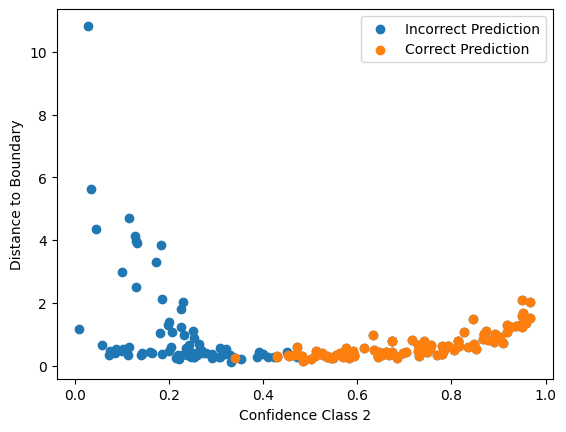

In [23]:
plt.scatter(true_images_B_df[true_images_B_df["label"]==2]["predictions_2"],B_class_2_to_boundary, label = "Incorrect Prediction")
plt.scatter(true_images_B_df[true_images_B_df["label"]==2][true_images_B_df["argmax_pred"]==2]["predictions_2"],B_class_2_correct_to_boundary, label = "Correct Prediction")
plt.ylabel("Distance to Boundary")
plt.xlabel("Confidence Class 2")
plt.legend()